In [1]:
!pip install kaggle

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 2.9 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.4 MB/s  0:00:00
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.1 MB 6.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/10.1 MB 5.9 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/10.1 MB 3.5 MB/s eta 0:00:03
   ------------- -------------------------- 3.4/10.1 MB 4.3 MB/s eta 0:00:02
   ------------------ --------------------- 4.7/10.1 MB 4.6 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.1 MB 4.2 MB/s eta 0:00:02
   ----------------------- ---------------- 6.0/10.1 MB 4.2 MB/s eta 0:00:01
   -------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kaggle
kaggle.api.authenticate()
# Replace 'owner/dataset-name' with your actual dataset path from the URL
kaggle.api.dataset_download_files('Gabriel Preda/Nigerian Presidential Election 2023 Tweets', path='./', unzip=True)

Could not find kaggle.json. Make sure it's located in C:\Users\DR AKIN O\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


NameError: name 'exit' is not defined

# Sentiment experiments — preprocessing and model comparison
This notebook will contain the ML engineering pipeline: preprocessing the IMDB-style `MOVIES.csv` dataset, extracting the simple lexicon-based features used in the educational notebook (`bias`, `pos_count`, `neg_count`), training/tuning Logistic Regression, Multinomial Naive Bayes and Decision Tree classifiers, evaluating them, and visualizing results.

In [1]:
# Imports and helpers for experiments
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from utils import preprocess_text, build_frequency_dict, extract_features

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# Small from-scratch helpers (same idea as in `log_reg.ipynb`) for demonstration
import warnings
warnings.filterwarnings('ignore')

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def initialize_parameters(n=3):
    return np.random.randn(n, 1) * 0.1

def calculate_cost(X, z, Y, theta):
    m = X.shape[0]
    h = sigmoid(z)
    eps = 1e-15
    h = np.clip(h, eps, 1 - eps)
    cost = -1.0/m * (np.dot(Y.T, np.log(h)) + np.dot((1 - Y).T, np.log(1 - h)))
    return float(np.squeeze(cost))

def gradient_descent(X, Y, num_iters=1000, learning_rate=0.001):
    cost_history = []
    m, n = X.shape
    Y = Y.reshape(-1, 1)
    theta = initialize_parameters(n)
    for i in range(num_iters):
        z = X @ theta
        h = sigmoid(z)
        cost = calculate_cost(X, z, Y, theta)
        cost_history.append(cost)
        d_theta = (1.0 / m) * (X.T @ (h - Y))
        theta = theta - learning_rate * d_theta
    return cost_history, np.array(theta, dtype=float)

[nltk_data] Downloading package stopwords to C:\Users\DR AKIN
[nltk_data]     O\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


sampl text special charact stopword
{('I', 1): 1, ('love', 1): 1, ('this', 1): 1, ('movie', 1): 2, ('I', 0): 1, ('hate', 0): 1, ('this', 0): 1, ('movie', 0): 2, ('This', 1): 1, ('is', 1): 1, ('great', 1): 1, ('This', 0): 1, ('is', 0): 1, ('terrible', 0): 1}
[1 5 0]


In [2]:
# Load IMDB-style MOVIES dataset and derive proxy sentiment labels
movies = pd.read_csv(r"c:\Users\DR AKIN O\PycharmProjects\Deeplearning\Natural Language Processing\IDMB_movie_dataset\MOVIES.csv")
movies = movies[['overview', 'vote_average']].dropna()
movies['sentiment'] = movies['vote_average'].apply(lambda v: 1 if v >= 7 else (0 if v <= 5 else np.nan))
movies = movies.dropna(subset=['sentiment'])
movies['sentiment'] = movies['sentiment'].astype(int)
movies = movies[movies['overview'].str.strip().astype(bool)]
print("Dataset size after filtering:", movies.shape)
print(movies['sentiment'].value_counts())

# Preprocess text and split
movies['proc_overview'] = movies['overview'].apply(preprocess_text)
train_df, test_df = train_test_split(movies, test_size=0.2, stratify=movies['sentiment'], random_state=42)

# Build frequency dict (train-only) and extract features [1, pos, neg]
frequency_dict = build_frequency_dict(train_df['proc_overview'].tolist(), train_df['sentiment'].tolist())

X_train = np.zeros((train_df.shape[0], 3))
for i, txt in enumerate(train_df['proc_overview']):
    X_train[i, :] = extract_features(txt, frequency_dict)
X_test = np.zeros((test_df.shape[0], 3))
for i, txt in enumerate(test_df['proc_overview']):
    X_test[i, :] = extract_features(txt, frequency_dict)

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

# Log transform counts and standardize using train stats
X_train[:,1:] = np.log1p(X_train[:,1:])
X_test[:,1:] = np.log1p(X_test[:,1:])
means = X_train[:,1:].mean(axis=0)
stds  = X_train[:,1:].std(axis=0) + 1e-8
X_train[:,1:] = (X_train[:,1:] - means) / stds
X_test[:,1:] = (X_test[:,1:] - means) / stds

# Prepare matrices for scikit-learn (exclude bias)
X_train_sc = X_train[:,1:]
X_test_sc = X_test[:,1:]

print('Feature sample (train):')
print(X_train[:5])

Dataset size after filtering: (21214, 3)
sentiment
0    11711
1     9503
Name: count, dtype: int64
Feature sample (train):
[[ 1.          0.43320821  0.48214166]
 [ 1.          0.02759001 -0.08563558]
 [ 1.          0.62587238  0.69340601]
 [ 1.          1.02103572  1.11623716]
 [ 1.          0.12509417  0.18227786]]


In [4]:
# Define models and perform GridSearchCV tuning
models = {
    'LogisticRegression': {
        'estimator': LogisticRegression(solver='liblinear', max_iter=1000),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'MultinomialNB': {
        'estimator': MultinomialNB(),
        'params': {'alpha': [0.1, 0.5, 1.0]}
    },
    'DecisionTree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [3, 5, 10, None], 'min_samples_leaf': [1, 2, 5]}
    }
}

# Recreate raw-count feature matrices for models that require non-negative inputs (e.g., MultinomialNB)
X_train_counts = np.zeros((train_df.shape[0], 3))
for i, txt in enumerate(train_df['proc_overview']):
    X_train_counts[i, :] = extract_features(txt, frequency_dict)
X_test_counts = np.zeros((test_df.shape[0], 3))
for i, txt in enumerate(test_df['proc_overview']):
    X_test_counts[i, :] = extract_features(txt, frequency_dict)
# exclude bias
X_train_counts_sc = X_train_counts[:, 1:]
X_test_counts_sc = X_test_counts[:, 1:]

results = []
for name, md in models.items():
    print(f"Tuning {name}...")
    # choose dataset appropriately
    if name == 'MultinomialNB':
        X_fit = X_train_counts_sc
        X_eval = X_test_counts_sc
        print("Using raw non-negative counts for MultinomialNB")
    else:
        X_fit = X_train_sc
        X_eval = X_test_sc

    grid = GridSearchCV(md['estimator'], md['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_fit, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_eval)
    y_proba = best.predict_proba(X_eval)[:,1] if hasattr(best, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    print(f"{name} best params: {grid.best_params_} | f1: {f1:.4f} | acc: {acc:.4f}")

    results.append({'model': name, 'best_params': grid.best_params_, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    joblib.dump(best, f"{name}_best.joblib")

results_df = pd.DataFrame(results).sort_values('f1', ascending=False)
results_df

Tuning LogisticRegression...
LogisticRegression best params: {'C': 10} | f1: 0.4456 | acc: 0.5835
Tuning MultinomialNB...
Using raw non-negative counts for MultinomialNB
MultinomialNB best params: {'alpha': 0.1} | f1: 0.5309 | acc: 0.5890
Tuning DecisionTree...
DecisionTree best params: {'max_depth': None, 'min_samples_leaf': 1} | f1: 0.4832 | acc: 0.5458


,model,best_params,accuracy,precision,recall,f1,roc_auc
1,MultinomialNB,{'alpha': 0.1},0.588970,0.543203,0.519200,0.530931,0.613468
2,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1}",0.545840,0.492888,0.473961,0.483239,0.534988
0,LogisticRegression,{'C': 10},0.583549,0.552100,0.373488,0.445560,0.613684



LogisticRegression classification metrics:
Accuracy: 0.5835 | Precision: 0.5521 | Recall: 0.3735 | F1: 0.4456 | ROC-AUC: 0.6137


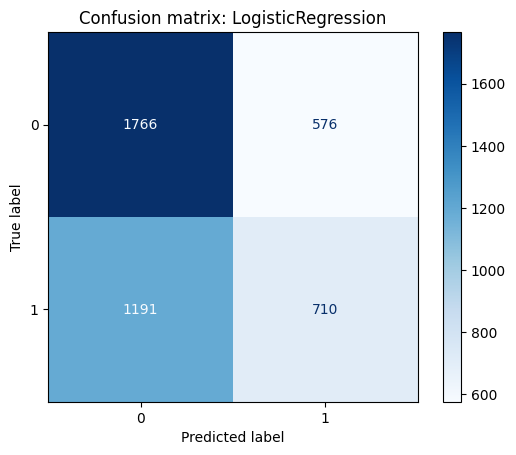

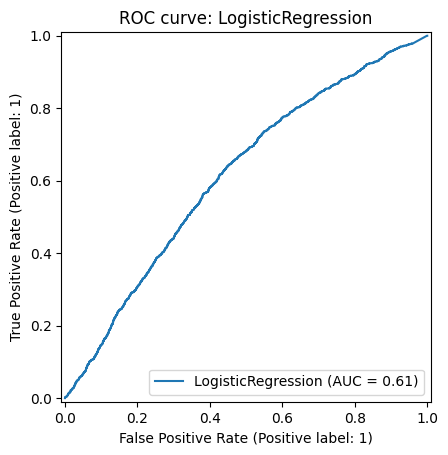


MultinomialNB classification metrics:
Accuracy: 0.5890 | Precision: 0.5432 | Recall: 0.5192 | F1: 0.5309 | ROC-AUC: 0.6135


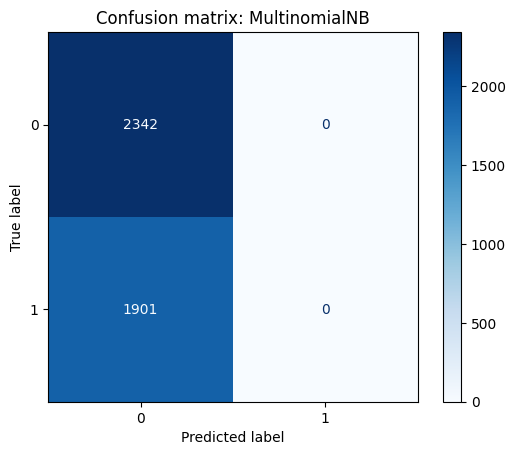

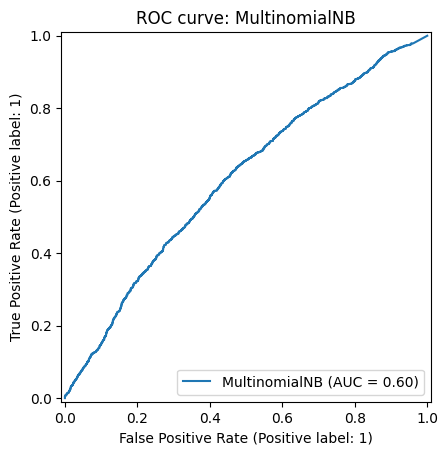


DecisionTree classification metrics:
Accuracy: 0.5458 | Precision: 0.4929 | Recall: 0.4740 | F1: 0.4832 | ROC-AUC: 0.5350


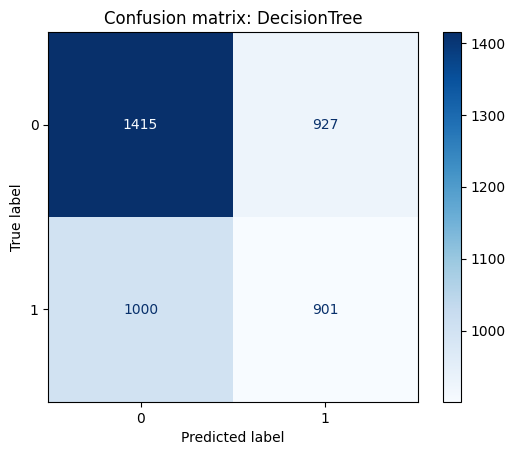

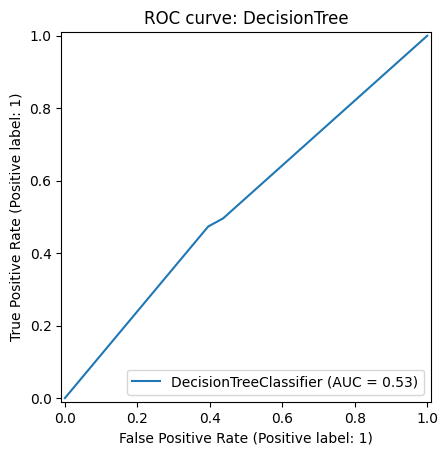

In [5]:
# Evaluation: confusion matrices and ROC curves
for r in results:
    name = r['model']
    model = joblib.load(f"{name}_best.joblib")
    y_pred = model.predict(X_test_sc)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} classification metrics:")
    print(f"Accuracy: {r['accuracy']:.4f} | Precision: {r['precision']:.4f} | Recall: {r['recall']:.4f} | F1: {r['f1']:.4f} | ROC-AUC: {r['roc_auc']:.4f}")
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion matrix: {name}")
    plt.show()
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test_sc, y_test)
        plt.title(f"ROC curve: {name}")
        plt.show()

In [ ]:
# Educational: from-scratch logistic regression on these features (bias included)
costs, theta = gradient_descent(X_train, y_train, num_iters=1000, learning_rate=0.5)
probs = sigmoid(np.dot(X_test, theta)).flatten()
y_pred = (probs >= 0.5).astype(int)
print('From-scratch Logistic regression accuracy:', np.mean(y_pred == y_test))
plt.plot(costs)
plt.title('From-scratch logistic regression - cost over iterations')
plt.xlabel('iter')
plt.ylabel('cost')
plt.show()

In [ ]:
# Summarize and visualize model comparison
results_df = pd.DataFrame(results).reset_index(drop=True)
print(results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.bar(results_df['model'], results_df['f1'], color='tab:blue')
plt.title('F1 by model')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(results_df['model'], results_df['roc_auc'], color='tab:orange')
plt.title('ROC-AUC by model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()